In [1]:
from MDAnalysis import Universe
import pandas as pd
import numpy as np

from marching_cubes import march
from seaborn import kdeplot
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
import plotly.graph_objs as go

import fresnel

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from scipy.spatial.distance import cdist

from skimage import measure

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
radius_lookup = {}
radius_lookup['C']=1.7
radius_lookup['H']=1.0
radius_lookup['N']=1.625
radius_lookup['O']=1.49
radius_lookup['S']=1.782

u=Universe('kras.pdb')
atoms =u.atoms
positions = atoms.positions
radii = np.array([radius_lookup[i] for i in atoms.types])

proberadius = 1.4

In [3]:
def plotly_scatter(pointsets, sizes):
    data = []
    for p, s in zip(pointsets, sizes):
        a,b,c = p[:,0], p[:,1], p[:,2]
        trace = go.Scatter3d(x=a, y=b, z=c, mode='markers', marker={'size': s,'opacity': 0.8,})
        data.append(trace)
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(plot_figure)
    
def fresnel_mesh(vol, cutoff, n_samples=10, view=None, spacing=(1,1,1)):
    if view is not None:
        view = view
    else:
        view='front'
    #vert, norm, faces = march(vol, smooth) 
    vert, faces, norm, values= measure.marching_cubes_lewiner(vol, cutoff,spacing=(1,1,1))
    scene1 = fresnel.Scene()
    geom = fresnel.geometry.Mesh(scene1,vertices=vert[faces].reshape(-1,3),N=1)
    geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
    scene1.camera = fresnel.camera.fit(scene1,view=view, margin=0)
    scene1.lights = fresnel.light.cloudy()
    return fresnel.pathtrace(scene1, samples=n_samples, h=600, w=600)

In [4]:
atom_centres = positions.copy()
atom_centres -= np.min(atom_centres,0)



scene_volume = np.max(atom_centres) #angstroms
grid_spacing = 0.5
buffer = 3 #angstrom
grid_size = int(np.rint(scene_volume / grid_spacing) + np.rint(2*buffer/grid_spacing))

proberadius = proberadius/grid_spacing
radii = radii/grid_spacing

In [75]:
plotly_scatter([atom_centres],[10])

In [5]:
#create a grid of the correct size:
a,b,c = np.ones([grid_size, grid_size, grid_size]).nonzero()
gPoints = np.vstack([a,b,c]).T
print('Grid shape is:',grid_size, 'and total points:', gPoints.shape)

Grid shape is: 103 and total points: (1092727, 3)


In [10]:
from scipy.spatial import cKDTree
voronoi_kdtree = cKDTree((atom_centres+buffer)/grid_spacing,leafsize=5)

In [33]:
distances, neighbours = voronoi_kdtree.query(gPoints, k=4)
#make distances relative to surface of expanded atoms:
distances = distances-radii[neighbours]

In [34]:
#set the grid values to their minimum distances to an atom (minus the radii)
grid = np.zeros([grid_size, grid_size,grid_size])
grid[gPoints[:,0], gPoints[:,1], gPoints[:,2]]=(1/(np.abs(distances))).sum(1)

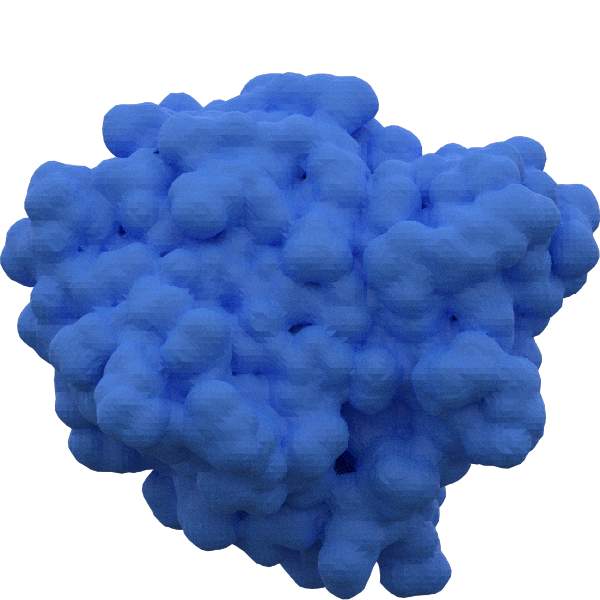

In [40]:
##IT's ok if this goes outside the scene - this view shows both the outside and the inside meshes! The outside
##will be discarded
fresnel_mesh(np.log(grid),1, n_samples=200)

In [41]:
import igl

In [ ]:
#vert, norm, faces = march(vol, smooth) 


vert, faces, norm, values= measure.marching_cubes_lewiner(np.log(grid), 0.9)
lv, lf = igl.loop(vert, faces)

scene1 = fresnel.Scene()
geom = fresnel.geometry.Mesh(scene1,vertices=lv[lf].reshape(-1,3),N=1)
geom.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]), roughness=0.6)
scene1.camera = fresnel.camera.fit(scene1,view='front', margin=0)
scene1.lights = fresnel.light.cloudy()
fresnel.pathtrace(scene1, samples=200, h=900, w=900)